In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import pyDOE
from multiprocessing import Process
from scipy.stats import norm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params, update_sev_prevalence
from analysis_helpers import poisson_waiting_function

from multi_group_simulation import MultiGroupSimulation

# Utility Functions

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [4]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

# Parameter Uncertainties

In [5]:
param_uncertainty = {
    'asymp_prob_mult': (24/47, 70/47), # Our nominal estimate for US population: 47%
    'inital_prev_mult': (0.5, 1.5),
    'R0': (1,4),
    'outside_inf_mult': (0.5, 1.5),
    'daily_self_report_prob': (0.22, 0.5),
    'ct_mult': (1,2),
    'ct_testing_ratio': (0.5, 1.5),
    'test_sensitivity': (0.4, 0.8),
    'test_noncompliance': (0.05, 0.15),
    'E_time': (1,3),
    'ID_time': (2,4),
    'Sy_time': (11,13),
    'virtual_noncompliance': (0.25, 0.75),
    'intermittent_non-compliance': (0.25,0.75),
    'virtual_r0_mult': (0.97, 1.5),
    'virtual_pop_size': (0,1), # Slider from min to max
}

uncertainty_params_list = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance', 'virtual_r0_mult',
                           'virtual_pop_size']

lb = list()
ub = list()

for param in uncertainty_params_list:
    lb.append(param_uncertainty[param][0])
    ub.append(param_uncertainty[param][1])

In [6]:
np.random.seed(2021)

dim = len(param_uncertainty.keys())
num_samples = 2000
lhs_points = pyDOE.lhs(dim, samples=num_samples)

for i in range(dim):
    lhs_points[:, i] = (1 - lhs_points[:,i]) * lb[i] + lhs_points[:,i] * ub[i]

# lhs_points[:,1], (1 - lhs_points[:,1]) * lb[1] + lhs_points[:,1] * ub[1], lb[1], ub[1]
# lhs_points[:,15], 1 - lhs_points[:,15]
# lhs_points[:,7]

In [7]:
def get_nominal_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/nominal/'
    
    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    return params_list, interaction_matrix, group_names

In [8]:
def rescale_virtual_interaction_matrix(perc_compliant, group_sizes):
    interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                    [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                    [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                    [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                                   ])
    interaction_matrix[0,0] = (8.8651 + 2.2163) * (1 - perc_compliant)
    interaction_matrix[0,1] = (8.8651 + 2.2163) * (perc_compliant)
    interaction_matrix[1,1] = (8.8651 + 2.2163) * (perc_compliant)
    
    interaction_matrix[3,3] = (6.9926 + 1.7482) * (1 - perc_compliant)
    interaction_matrix[3,4] = (6.9926 + 1.7482) * perc_compliant
    interaction_matrix[4,4] = (6.9926 + 1.7482) * perc_compliant
    
    for i in range(interaction_matrix.shape[0]):
        for j in range(i):
            if ((i,j) == (0,0)) or ((i,j)==(0,1)) or ((i,j)==(1,1)):
                continue
            interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]
    return interaction_matrix


def get_virtual_params(perc_unmonitored, ug_pop, gs_other_pop):
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/virtual_instruction/'

    gs_research_params = load_params(base_directory + 'grad_research_virtual.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age_virtual.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age_virtual.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age_virtual.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community_virtual.yaml')[1]

    ug_off_campus_unmonitored_params = load_params(base_directory + 'ug_off_campus_unmonitored_virtual.yaml')[1]
    ug_off_campus_compliant_params = load_params(base_directory + 'ug_off_campus_compliant_virtual.yaml')[1]
    gs_other_unmonitored_params = load_params(base_directory + 'grad_other_unmonitored_virtual.yaml')[1]
    gs_other_compliant_params = load_params(base_directory + 'grad_other_compliant_virtual.yaml')[1]
    
#     total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
    ug_off_campus_unmonitored_params['population_size'] = np.ceil(perc_unmonitored * ug_pop)
    ug_off_campus_compliant_params['population_size'] = np.floor((1-perc_unmonitored) * ug_pop)
    
#     total_gs_other_pop = gs_other_unmonitored_params['population_size'] + gs_other_compliant_params['population_size']
    gs_other_unmonitored_params['population_size'] = np.ceil(perc_unmonitored * gs_other_pop)
    gs_other_compliant_params['population_size'] = np.floor((1-perc_unmonitored) * gs_other_pop)
    
    params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    group_names = ['UG unmonitored', 'UG compliant', 'GS research', 'GS unmonitored', 'GS compliant', 'F/S student', 'F/S non-student', 'F/S off', 'Ithaca']
    virtual_group_sizes = list()
    for params in params_list:
        virtual_group_sizes.append(params['population_size'])
    interaction_matrix = rescale_virtual_interaction_matrix(1 - perc_unmonitored, virtual_group_sizes)
    
    return params_list, interaction_matrix, group_names

In [9]:
get_nominal_params()[0][0]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


{'severity_prevalence': array([0.52 , 0.472, 0.006, 0.002]),
 'population_size': 4167,
 'initial_ID_prevalence': 0.001558,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'exposed_infection_p': 0.018,
 'expected_contacts_per_day': 12.5,
 'daily_outside_infection_p': 1.2e-05,
 'mild_symptoms_daily_self_report_p': 0,
 'severe_symptoms_daily_self_report_p': 0.22,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<

In [9]:
def get_test_FNR(sensitivity, compliance):
    if 1 - (sensitivity * compliance) > 1:
        print(sensitivity, compliance)
    return 1 - (sensitivity * compliance)

def adjust_params(uncertainty_point):
    res_params_list, res_interaction_matrix, res_group_names = get_nominal_params()
    virtual_persistent_noncompliance = uncertainty_point[12]
    virtual_ug_pop = 4500 * (1 - uncertainty_point[15]) + 7950 * uncertainty_point[15]
    virtual_gs_other_pop = 4770 * (1 - uncertainty_point[15]) + 5850 * uncertainty_point[15]
    virtual_params_list, virtual_interaction_matrix, virtual_group_names = get_virtual_params(virtual_persistent_noncompliance, virtual_ug_pop, virtual_gs_other_pop)

    # Asmptomatic Prob Mult
    for params in res_params_list:
        params['severity_prevalence'] = update_sev_prevalence(params['severity_prevalence'], uncertainty_point[0] * params['severity_prevalence'][0])
        if params['severity_prevalence'][0] > 1:
            params['severity_prevalence'] = [1,0,0,0]
    for params in virtual_params_list:
        params['severity_prevalence'] = update_sev_prevalence(params['severity_prevalence'], uncertainty_point[0] * params['severity_prevalence'][0])
        if params['severity_prevalence'][0] > 1:
            params['severity_prevalence'] = [1,0,0,0]
    
    # Initial Prevalence Mult
    for params in res_params_list:
        params['initial_ID_prevalence'] *= uncertainty_point[1]
    for params in virtual_params_list:
        params['initial_ID_prevalence'] *= uncertainty_point[1]
    
    # R0 adjustment
    res_interaction_matrix *= uncertainty_point[2]/2.5
    virtual_interaction_matrix *= uncertainty_point[2] * uncertainty_point[14]/2.5
    
    # Outside inf mult
    for params in res_params_list:
        params['daily_outside_infection_p'] *= uncertainty_point[3]
    for params in virtual_params_list:
        params['daily_outside_infection_p'] *= uncertainty_point[3]
    
    # Daily self-report prob
    for params in res_params_list:
        params['severe_symptoms_daily_self_report_p'] = uncertainty_point[4]
    for params in virtual_params_list:
        params['severe_symptoms_daily_self_report_p'] = uncertainty_point[4]
        
    # CT mult
    for params in res_params_list:
        params['cases_isolated_per_contact'] *= uncertainty_point[5]
    for params in virtual_params_list:
        params['cases_isolated_per_contact'] *= uncertainty_point[5]
    
    # CT testing ratio
    for params in res_params_list:
        params['contact_trace_testing_frac'] = uncertainty_point[6]
    for params in virtual_params_list:
        params['contact_trace_testing_frac'] = uncertainty_point[6]
    
    # Test sensitivity and Test compliance (note: non-compliance is provided in uncertainty point)
    for params in res_params_list:
        params['test_protocol_QFNR'] = get_test_FNR(uncertainty_point[7], 1-uncertainty_point[8])
    for params in virtual_params_list:
        params['test_protocol_QFNR'] = get_test_FNR(uncertainty_point[7], 1-(uncertainty_point[13]))

    # E_time, ID_time, Sy_time
    for params in res_params_list:
        params['exposed_time_function'] = poisson_waiting_function(7, uncertainty_point[9])
        params['ID_time_function'] = poisson_waiting_function(8, uncertainty_point[10])
        params['SyID_mild_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        params['SyID_severe_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
    
    for params in virtual_params_list:
        params['exposed_time_function'] = poisson_waiting_function(7, uncertainty_point[9])
        params['ID_time_function'] = poisson_waiting_function(8, uncertainty_point[10])
        params['SyID_mild_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        params['SyID_severe_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        
    return (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names)

In [39]:
def run_simulation(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(uncertainty_point)

    # run simulations
    # Residential Simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
    
#     print(res_params_list[0]['severity_prevalence'])
#     for params in res_params_list:
#         if params['test_protocol_QFNR'] < 0 or params['test_protocol_QFNR'] > 1:
#             print(params['test_protocol_QFNR'])
#     for params in virtual_params_list:
#         if params['test_protocol_QFNR'] < 0 or params['test_protocol_QFNR'] > 1:
#             print(params['test_protocol_QFNR'])
    
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)
    
    # Running virtual sims
    print('Virtual Sim', point_id)
    virtual_tests_per_day, virtual_inf_matrix, virtual_hosp_matrix = evaluate_testing_policy(virtual_params_list, virtual_interaction_matrix, virtual_group_names, virtual_test_policy, 112, 50)
    
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix], file)
    file.close()    
    return

In [40]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_simulation, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [ ]:
processes = []
for i in range(lhs_points.shape[0]):
# for i in range(20):
    point = lhs_points[i,:]
    p = run_new_process(point, 'apr_24_scenarios/point_'+str(i)+'.dill', i)
    processes.append(p)

# p = run_sims_new_process(ct_delay_sensitivity, 'res_inst_paper_graphs/apr_5_sens_ct_delay.dill')
# processes.append(p)
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 0


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 4


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 2


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 3
Res Sim 5


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 10


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 11
Res Sim 9


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 6


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 12


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 8
Res Sim 7
Res Sim 16


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 13
Res Sim 17
Res Sim 14


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 15


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 20


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 23


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 22


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 21
Res Sim 24


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 26


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 18


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 19
Res Sim 25
Res Sim 27


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 29
Res Sim 28
Res Sim 38
Res Sim 30
Res Sim 37


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 40


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 32
Res Sim 31
Res Sim 33


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 35


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 36
Res Sim 34
Res Sim 47
Res Sim 39


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 42


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 41


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 45


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 49
Res Sim 43
Res Sim 44
Res Sim 46


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 52


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 51
Res Sim 48


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 50
Res Sim 54


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Res Sim 57
Res Sim 55


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 58
Res Sim 56
Res Sim 53


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 60
Res Sim 59


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 61


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 62


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 63


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 65


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 64


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 67


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 66


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 69


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 68


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 72


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 70


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 71
Res Sim 77
Res Sim 79
Res Sim 75


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 76


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 74


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 73


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 81


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 83
Res Sim 82


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 78


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 85


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 80
Res Sim 87


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 86


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 84


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 94
Res Sim 92
Res Sim 89


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 88


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 90
Res Sim 93


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 91


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 99


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 95


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 96
Res Sim 98


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 104
Res Sim 102


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 106
Res Sim 100
Res Sim 97
Res Sim 101


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 105
Res Sim 109


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 103
Res Sim 107


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 111


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 112
Res Sim 108


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 116


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 114
Res Sim 110


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 117


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 113


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 121
Res Sim 115


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 118


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 119


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 122


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 120
Res Sim 125


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 123


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 127


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 131
Res Sim 126


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 130


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 129
Res Sim 128
Res Sim 124
Res Sim 132


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 133


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 136


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 135


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 137
Res Sim 134


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 139
Res Sim 141


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 140


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 143
Res Sim 142
Res Sim 138


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 146
Res Sim 145


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 147


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 144


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 149


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 151


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 148
Res Sim 150


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 152


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 153


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 155


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 154
Res Sim 156
Res Sim 157


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 158


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 161
Res Sim 159
Res Sim 162
Res Sim 160


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 163


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 164
Res Sim 165


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 166


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 168


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 170
Res Sim 169


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 172
Res Sim 167
Res Sim 176
Res Sim 171
Res Sim 175
Res Sim 174
Res Sim 173
Res Sim 178


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 177


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 181


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 180
Res Sim 184
Res Sim 183
Res Sim 182
Res Sim 179


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 186


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 187
Res Sim 185


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 189


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 188
Res Sim 191


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 192


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 193


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 195


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 190


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 196
Res Sim 194


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 197


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 198


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 199


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 204


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 200


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 203
Res Sim 205
Res Sim 202
Res Sim 207
Res Sim 206


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 201


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 209


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 210


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 213


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 208


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 211
Res Sim 215


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 216


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 212
Res Sim 221
Res Sim 219
Res Sim 218
Res Sim 217


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 214


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 220


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 224
Res Sim 223


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 225


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 222


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 227
Res Sim 228


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 226


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 229


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 230


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 232


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 231


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 233


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 238


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 237


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 234


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 236


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 235
Res Sim 240


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 239


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 241


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 242


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 243


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 244
Res Sim 246


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 245


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 251


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 249
Res Sim 250
Res Sim 247
Res Sim 248


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 252


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 253


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 254
Res Sim 255


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 256


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 259


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Res Sim 257
Res Sim 258
Res Sim 261
Res Sim 260


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 262


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 263


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 264


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 265


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 270


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 266


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 271
Res Sim 267


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 268


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 269


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 273


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 272
Res Sim 276
Res Sim 274


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 278


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 277


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 279


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 275


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 280


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 281


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Res Sim 283


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 287


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 285
Res Sim 282


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 284


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 288


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 286


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 289


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 290
Res Sim 291


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 294


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 292


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 298
Res Sim 295
Res Sim 297
Res Sim 293


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 296
Res Sim 301


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 300
Res Sim 302


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 299
Res Sim 306
Res Sim 303


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 308
Res Sim 305


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 307


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 304


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 310


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 309


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 311
Res Sim 312


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 314
Res Sim 313


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 315


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 317


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 316
Res Sim 319


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 318


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 320


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 321


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 322


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 323


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 324


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 325


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 330
Res Sim 326


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 328


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 327
Res Sim 331
Res Sim 329


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 332


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 333


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 335
Res Sim 334


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 338
Res Sim 336


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 340


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 337


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 341


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 339
Res Sim 342


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 343


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 344


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 345


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 347


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 348
Res Sim 349
Res Sim 346


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 350
Res Sim 351


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 354


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 352


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 356


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 355
Res Sim 353


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 357


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 358


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 359


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 363
Res Sim 361


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 362
Res Sim 360


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 366


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 364
Res Sim 365
Res Sim 367


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 369


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 368


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 371
Res Sim 370
Res Sim 374
Res Sim 372


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 373


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 375


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 377


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 376


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 378
Res Sim 379


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 383


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 381
Res Sim 382


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 385
Res Sim 380


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 384


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 386


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 387
Res Sim 388


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 389


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 390


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 392


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 402
Res Sim 401


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 398


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 393


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 396
Res Sim 397


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 404


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 399
Res Sim 394
Res Sim 400
Res Sim 391
Res Sim 403
Res Sim 406


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 395


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 405


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 407


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 408


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 410


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 411


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 412


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 409


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 413
Res Sim 415
Res Sim 414
Res Sim 416
Res Sim 417
Res Sim 418


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 419


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 422
Res Sim 420


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 423
Res Sim 421
Res Sim 424


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 426
Res Sim 427


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 425


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 429


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 428
Res Sim 431


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 430


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 433


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 435


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 432
Res Sim 434


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 438


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 436


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 437


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 439
Res Sim 440


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 444
Res Sim 441


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 446


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 442


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 445
Res Sim 447
Res Sim 448


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 443


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 449


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 450
Res Sim 451
Res Sim 453
Res Sim 454


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 452


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 456


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 455


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 457


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 458
Res Sim 459


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 460


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 461
Res Sim 463
Res Sim 467
Res Sim 462


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 465
Res Sim 464


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 469


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 466
Res Sim 468


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 470


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 472


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 474


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 478
Res Sim 471


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 473


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 477
Res Sim 475
Res Sim 479
Res Sim 480


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 476


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 481


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 483


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 482


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 484
Res Sim 485
Res Sim 487


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 488
Res Sim 486


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 493
Res Sim 491


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 494


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 490
Res Sim 492


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 489
Res Sim 495


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 497


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 496


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 498
Res Sim 499


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 501


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 500


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 502


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 503


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 504
Res Sim 505


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 506
Res Sim 507


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 509


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 508


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 510


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 511


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 512


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 515
Res Sim 514


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 518
Res Sim 517
Res Sim 513


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 516


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 520


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 522


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 519
Res Sim 521


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 525


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 523
Res Sim 526


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 528
Res Sim 524
Res Sim 527


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 529
Res Sim 532


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 530


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 533
Res Sim 535


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 531


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 534


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 537
Res Sim 536
Res Sim 538


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 539


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 540


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 542
Res Sim 543


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 541


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 544


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 545


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 548


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 546


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 551


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 549


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 547
Res Sim 550


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 552


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 553


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 556


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 554


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 555


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 557


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 558
Res Sim 561
Res Sim 560
Res Sim 562
Res Sim 559


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 565


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 567


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 566


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 564


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 563


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 568
Res Sim 573
Res Sim 570


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 571
Res Sim 569


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 574


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 572


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 575


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 576


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 580


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 579


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 583
Res Sim 582


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 581
Res Sim 578


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 584
Res Sim 577


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 586
Res Sim 585


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 587
Res Sim 590


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 589


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 588
Res Sim 591
Res Sim 592
Res Sim 594
Res Sim 595


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 593
Res Sim 596


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 597


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 598
Res Sim 599


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 601


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 600


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 602


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 603
Res Sim 604


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 605


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 606


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 607
Res Sim 608


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 609


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 611


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 612


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 613


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 615
Res Sim 610


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 614


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 616


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 617


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 618


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 621
Res Sim 619


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 624
Res Sim 620


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 622
Res Sim 625


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 623
Res Sim 628


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 627


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 630


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 626
Res Sim 629
Res Sim 632


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 631


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 633


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 634
Res Sim 636
Res Sim 635


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 638
Res Sim 640
Res Sim 637


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 641


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 639


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 642


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 643


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 644


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 645
Res Sim 647
Res Sim 646


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 648


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 650


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 649


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 651
Res Sim 654
Res Sim 652


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 653


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 655
Res Sim 656


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 658


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 657


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 659


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 660


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 661


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 662


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 663


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 665


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 664


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 666


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 669


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 670


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 668


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 671
Res Sim 673


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 672


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 667
Res Sim 674


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 675


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 677
Res Sim 676


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 679


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 678


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 680


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 681


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 683


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 682


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 684
Res Sim 685


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 686
Res Sim 688


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 687


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 690


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 689


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 691


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 695


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 692


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 693


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 696
Res Sim 698
Res Sim 694


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 700
Res Sim 699


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 697


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 702


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 703


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 701


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 705


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 707


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 704


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 706
Res Sim 708
Res Sim 709


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 711


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 710
Res Sim 713


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 712


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 714


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 715
Res Sim 716


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 717


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 718
Res Sim 719


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 721


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 720


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 722


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 723


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 725
Res Sim 724


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 726


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 727


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 728
Res Sim 729


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 730


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 731
Res Sim 733
Res Sim 732
Res Sim 734
Res Sim 736


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 735
Res Sim 738
Res Sim 737


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 739


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 740


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 741


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 742


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 743


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 745


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 744


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 750
Res Sim 746


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 748


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 752
Res Sim 749


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 753


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 751
Res Sim 747


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 757
Res Sim 756
Res Sim 754
Res Sim 755


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 758
Res Sim 759


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 760


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 765


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 763


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 761
Res Sim 762


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 767
Res Sim 764


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 768


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 769
Res Sim 766


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 770


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 771


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 776
Res Sim 773


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 774
Res Sim 775
Res Sim 772


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 777


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 779


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 778


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 781


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 783


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 782
Res Sim 780


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 784


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 785
Res Sim 786


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 788


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 787


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 789


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 790


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 791


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 792
Res Sim 793


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 795


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 794


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 799
Res Sim 797


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 798


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 796


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 800


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 801
Res Sim 802


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 804
Res Sim 805
Res Sim 803


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 810


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 808


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 806


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 807
Res Sim 811
Res Sim 812
Res Sim 814
Res Sim 809


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 813


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 815


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 817
Res Sim 818
Res Sim 816


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 819


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 820


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 823


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 822
Res Sim 821


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 825


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 829


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 826


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 828


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 827


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 824


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 832
Res Sim 830


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 831


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 833


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 834


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 836


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 837


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 835


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 839
Res Sim 838


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 844
Res Sim 840
Res Sim 846
Res Sim 841


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 845
Res Sim 847


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 850


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 843
Res Sim 842


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 848


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 849


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 851


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 852


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 855


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 854
Res Sim 857
Res Sim 853


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 860
Res Sim 858
Res Sim 859
Res Sim 861


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 856


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 864
Res Sim 865


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 862
Res Sim 863


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 866
Res Sim 867


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 868


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Res Sim 869


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 871
Res Sim 870
Res Sim 872


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 873


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 875


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 876
Res Sim 874


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 877


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 878
Res Sim 879
Res Sim 880


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 881


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 882
Res Sim 885


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 884
Res Sim 883


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 888


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 892


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 887
Res Sim 893
Res Sim 889


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 886


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 890


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 891


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 895


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 896


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 894


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 898
Res Sim 897


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 900


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 899


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 901


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 902
Res Sim 903


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 905
Res Sim 906


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 904


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 909
Res Sim 910
Res Sim 908


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 907


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 911
Res Sim 912
Res Sim 913


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 915
Res Sim 914


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 917
Res Sim 918
Res Sim 916
Res Sim 919


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 920


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 922
Res Sim 921


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 923
Res Sim 924


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 925


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 926


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 927


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 928


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 930
Res Sim 929


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 931


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 932
Res Sim 933


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 934


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 935
Res Sim 936


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 937


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 939
Res Sim 938


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 940


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 942


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 941


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 943
Res Sim 944
Res Sim 946
Res Sim 945


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 947


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 948


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 950


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 954


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 952


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 949
Res Sim 951
Res Sim 956


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 955


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 953
Res Sim 957


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 959
Res Sim 958


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 960


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 963


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 965
Res Sim 962
Res Sim 961


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 964


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 966
Res Sim 967


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 970
Res Sim 968


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 969


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 971


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 972


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 976
Res Sim 974


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 975
Res Sim 973
Res Sim 977


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 978


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 979
Res Sim 980


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 981


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 982


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 983
Res Sim 984


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 985
Res Sim 986


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 987


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 991
Res Sim 989
Res Sim 988


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 990


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 993


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 992
Res Sim 994


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 997
Res Sim 995
Res Sim 998
Res Sim 996


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 999


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1001


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1000


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1003


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1004
Res Sim 1002
Res Sim 1005


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1007
Res Sim 1006


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1011


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1009


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1008


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1010


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1012


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1014


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1013


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1016
Res Sim 1015


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1017


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1018


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1019


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1020


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1022
Res Sim 1021


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1023


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1024


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1026


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1025


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1027


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1028


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1029


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1032


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1030


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1031


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1033


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1035
Res Sim 1034
Res Sim 1036
Res Sim 1037


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1041


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1040


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1039


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1044
Res Sim 1043
Res Sim 1038


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1042


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1045


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1046


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1047


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1049


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1048


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1051
Res Sim 1050


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1053


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1054
Res Sim 1052


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1055


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1056


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1058


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1057


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1060


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1059


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1062


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1061


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1063
Res Sim 1064


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1065
Res Sim 1066


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1068
Res Sim 1067


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1069


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1070
Res Sim 1072


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1071


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1074


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1073


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1075
Res Sim 1077


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1076


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1079


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1078


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 1080


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1083
Res Sim 1082


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1084


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1081


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1085


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1086


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1090


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1089


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1088


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1091


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1096


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1094
Res Sim 1092
Res Sim 1087


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1093


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1095
Res Sim 1097


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1098


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1101
Res Sim 1099


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1103


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1100


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1104


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1102


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1106


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1105


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1107


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1108


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1110
Res Sim 1109


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1111
Res Sim 1114


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1113


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1115
Res Sim 1112


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1116


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1117


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1119
Res Sim 1118


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1121


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1120


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1122


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1124


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1126
Res Sim 1123
Res Sim 1125
Res Sim 1127
Res Sim 1129


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1128
Res Sim 1130
Res Sim 1132
Res Sim 1134


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1133


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1131


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1135


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1136


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1137


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1139


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1138


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1146


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1142
Res Sim 1144
Res Sim 1145
Res Sim 1141


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1143


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1147
Res Sim 1151
Res Sim 1148
Res Sim 1140
Res Sim 1150


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1149


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1153


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1152


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1154


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1155


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1156
Res Sim 1158


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1157


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1159


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1160


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1161


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1163


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1164
Res Sim 1165


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1162


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1167
Res Sim 1166


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1168


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1171


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1172
Res Sim 1169


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1170


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1173
Res Sim 1177


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1174
Res Sim 1175


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1176
Res Sim 1179
Res Sim 1178


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1180


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1181
Res Sim 1182
Res Sim 1184


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1183


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1187
Res Sim 1186
Res Sim 1188
Res Sim 1185


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1189


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1191
Res Sim 1193
Res Sim 1190


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1192


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1194


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1197


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1196


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1195


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1199
Res Sim 1198


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1200


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1201
Res Sim 1202


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1203


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1204


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1206


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1205


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1208
Res Sim 1207


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1209
Res Sim 1210


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1212
Res Sim 1211


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1213


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1215
Res Sim 1214
Res Sim 1216


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1217


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1218


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1219


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1220


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1221
Res Sim 1223
Res Sim 1222


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1224


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1226
Res Sim 1225


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1228
Res Sim 1227


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1231
Res Sim 1230


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1229
Res Sim 1232


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1233


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1234


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1235
Res Sim 1236


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1238
Res Sim 1237


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1241
Res Sim 1239


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1240
Res Sim 1242


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1244


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1243


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1245


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1246


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1250


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1248
Res Sim 1247
Res Sim 1251


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1249


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1252
Res Sim 1253


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1254


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1256


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1255


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1257


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1258


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1259


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1263


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1264


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1262
Res Sim 1265


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1260
Res Sim 1267


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1261


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1266
Res Sim 1268


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1269
Res Sim 1272


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1270


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1271


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1274


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1277


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1273


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1275


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1276
Res Sim 1278
Res Sim 1279


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1280


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1281


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Res Sim 1283


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1282


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1284


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1286
Res Sim 1285


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1287


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1289


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1290


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1292


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1291


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1293


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1294
Res Sim 1295


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1288


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1300
Res Sim 1297


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1299
Res Sim 1296
Res Sim 1301


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1302


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1304
Res Sim 1305


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1303


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1298
Res Sim 1306


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1307


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1308


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1309
Res Sim 1310


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1311


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1312


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1313


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1314


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1315


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1316


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1318


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1317


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1319


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1322


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1320
Res Sim 1321


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1324
Res Sim 1323


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1325
Res Sim 1326


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1327


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1328


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1330


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1332


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1333


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1329


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1335


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1331


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1334
Res Sim 1336
Res Sim 1339
Res Sim 1337
Res Sim 1338


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1342


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1341
Res Sim 1340


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1343


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1344


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1345


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1346


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1347


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1348


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1349


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1351


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1350
Res Sim 1352


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 1355
Res Sim 1356
Res Sim 1354
Res Sim 1353


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1357


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1358


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1360


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1359


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1363
Res Sim 1366
Res Sim 1364
Res Sim 1368


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1365


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1367


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1362


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1361


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1369


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1373


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1371


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1372
Res Sim 1370


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1376


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1375
Res Sim 1377
Res Sim 1379


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1374
Res Sim 1378
Res Sim 1381


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1383
Res Sim 1384
Res Sim 1382
Res Sim 1385
Res Sim 1380


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1386


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1387


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1388


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1390


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1389


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1391


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1392
Res Sim 1394


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1393
Res Sim 1395


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1396


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1400
Res Sim 1402
Res Sim 1398
Res Sim 1399


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1401
Res Sim 1397
Res Sim 1403


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1405
Res Sim 1404


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1407


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1408


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1409


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1406


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1410


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1413


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1415


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1411
Res Sim 1412
Res Sim 1414
Res Sim 1416


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1417


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1420


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1418
Res Sim 1419
Res Sim 1423


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1424


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1421
Res Sim 1422


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1425


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1426


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1427


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1428


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1429


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1430
Res Sim 1432
Res Sim 1431
Res Sim 1433


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1434


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1436
Res Sim 1435


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1437


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1438


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1439


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1440


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1443


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1442


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1444
Res Sim 1441


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1445


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1447


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1446
Res Sim 1448


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1449


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1450
Res Sim 1451


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1452


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 1453


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1456
Res Sim 1454


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1455


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1457
Res Sim 1458


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1459


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1461


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1460


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1462


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1463


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1465


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1468
Res Sim 1466
Res Sim 1467


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1469


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1464


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1471
Res Sim 1470


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1472


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1474
Res Sim 1473


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1475


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1477


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1478
Res Sim 1476


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1479


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1480
Res Sim 1481


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1482


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1484
Res Sim 1483


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1486


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1485
Res Sim 1487
Res Sim 1488


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1489


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1490


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1491


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1492


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1493


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1495
Res Sim 1494


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1496


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1497


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1498


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1499
Res Sim 1500


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1502


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1501


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1503
Res Sim 1505


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1504


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1506
Res Sim 1507
Res Sim 1508


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1510


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1509


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1513
Res Sim 1511
Res Sim 1514
Res Sim 1512


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1516


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1515


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1517


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1518


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1519


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1521
Res Sim 1520


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1526
Res Sim 1524


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1527


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1525
Res Sim 1523
Res Sim 1528


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1529
Res Sim 1522


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1530
Res Sim 1531


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1532


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1533


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1535


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1537


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1538


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1534
Res Sim 1539


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1536


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1540


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1541


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1543


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1542
Res Sim 1545
Res Sim 1544


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1546


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1547


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1548


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1549


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1551
Res Sim 1552


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1550


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1554


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1553
Res Sim 1555


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1556
Res Sim 1557


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1558


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1559


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1560
Res Sim 1561


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1562


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1563


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1564


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1566


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1565
Res Sim 1567


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1569
Res Sim 1568
Res Sim 1571
Res Sim 1570


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1572


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1574


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1573


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1575


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1577
Res Sim 1576


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1578


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1579


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1581


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1580


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1583


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1582


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1584


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1585


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1586


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1587


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1588
Res Sim 1589


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1590
Res Sim 1591


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1593


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1592
Res Sim 1594
Res Sim 1595


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1597


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1596


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1600


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1599
Res Sim 1598


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1602
Res Sim 1601


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1603


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1604


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1605


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1606


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1607


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1608


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1609


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1611
Res Sim 1610


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1612


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1613


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1615
Res Sim 1614


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1616


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1617
Res Sim 1619
Res Sim 1618


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1620


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1621


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1624
Res Sim 1622


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1623


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1625


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1626


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1627
Res Sim 1630


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1629


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1631


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1628


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1632


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1633
Res Sim 1635


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1634


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1636


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1637


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1638


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1640


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1639


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1641


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1642


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1644


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1643


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1645
Res Sim 1647
Res Sim 1646


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1649


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1648


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1650


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1652


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1653


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1651


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1654


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1655


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1656


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1657


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1658


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1659


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1660


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1661
Res Sim 1663


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1662


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1664


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1665
Res Sim 1666
Res Sim 1667


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1669


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1668


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1671
Res Sim 1670


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1672


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1673


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1674
Res Sim 1676


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1675


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1677


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1680
Res Sim 1678


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1679
Res Sim 1682


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1681


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1683


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1684


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1686


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1685


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1687
Res Sim 1688


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1690


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1691


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1689


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1692


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1694
Res Sim 1696


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1693
Res Sim 1695


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1697


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1698


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1701


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1699


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1700
Res Sim 1702


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1703


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1704


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1705


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1706


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1707


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1709


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1708


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1710


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1713
Res Sim 1712


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1711


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1714


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1715


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1716
Res Sim 1717


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1718
Res Sim 1720
Res Sim 1719


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1721
Res Sim 1723
Res Sim 1722


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1724
Res Sim 1725


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1726


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1727


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1728


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1729


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1730


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1731


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1732


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1733


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1735
Res Sim 1734


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1737
Res Sim 1736


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1738


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1740
Res Sim 1739
Res Sim 1741


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1742


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1743


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1744


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1745


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1746


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1747
Res Sim 1749


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1748


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1750


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1751
Res Sim 1752


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1753


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1755


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1754
Res Sim 1756


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1757


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1759


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1758


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1760


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1763


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1761


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1762


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1765


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1766
Res Sim 1764


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1767


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1768


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1769


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1771
Res Sim 1770


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1772


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1773


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1775
Res Sim 1774


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1776


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1777


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1779
Res Sim 1778


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1781


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1782
Res Sim 1780


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1784


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1783


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1785


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1786


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1787


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1789
Res Sim 1788


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1792


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1790


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1791


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1793
Res Sim 1794


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1795
Res Sim 1796


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1797
Res Sim 1799


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1798
Res Sim 1801
Res Sim 1800


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1802


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1803
Res Sim 1805


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1804


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1806


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1808
Res Sim 1809
Res Sim 1807
Res Sim 1810
Res Sim 1812
Res Sim 1811


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1814
Res Sim 1813


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1816
Res Sim 1815
Res Sim 1817


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1818
Res Sim 1819


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1820


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1821


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1824
Res Sim 1823


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1825


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1826


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1822


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1827
Res Sim 1828
Res Sim 1829
Res Sim 1830
Res Sim 1831
Res Sim 1832


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1833


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1834
Res Sim 1835
Res Sim 1836


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1837


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1841


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1842


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1839
Res Sim 1840


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1838
Res Sim 1843


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1844


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1845


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1846


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1847
Res Sim 1851
Res Sim 1848
Res Sim 1850
Res Sim 1849


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1852


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1855


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1856
Res Sim 1853


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1854
Res Sim 1858
Res Sim 1857


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1860
Res Sim 1859
Res Sim 1861


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1862


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1863


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1865


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1864
Res Sim 1866
Res Sim 1868
Res Sim 1867


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1869


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1870


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

Res Sim 1872


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1873
Res Sim 1874
Res Sim 1871


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1875
Res Sim 1876
Res Sim 1877


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1878


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1880
Res Sim 1879
Res Sim 1881
Res Sim 1882
Res Sim 1883


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1884
Res Sim 1885


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1886


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1887
Res Sim 1888


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1889


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1891
Res Sim 1890


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1892


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1893


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1894


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1895


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1897


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1898
Res Sim 1896


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1899
Res Sim 1900
Res Sim 1901


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 1902


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1903


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1904
Res Sim 1905
Res Sim 1906
Res Sim 1908
Res Sim 1907


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

Res Sim 1910
Res Sim 1909


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1911
Res Sim 1912


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1918


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1914


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1913


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1915
Res Sim 1920
Res Sim 1917


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1919
Res Sim 1916


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1922
Res Sim 1923
Res Sim 1921


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1926


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1924
Res Sim 1925


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1927
Res Sim 1929
Res Sim 1930
Res Sim 1931
Res Sim 1928


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1932


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1933


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1934


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1936


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1935


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1937


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1938


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1940
Res Sim 1939


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1944


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1943
Res Sim 1942


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 1941


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1945


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1947


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1946


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1948


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1949


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1950


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1951


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1952
Res Sim 1953
Res Sim 1954


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1955
Res Sim 1956
Res Sim 1957


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1958


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1959


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1960


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1961


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1966


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1965
Res Sim 1967
Res Sim 1962
Res Sim 1968


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1964
Res Sim 1963


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1969


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 1971


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1973
Res Sim 1970


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1972
Res Sim 1974


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1975
Res Sim 1976


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1977


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1978


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1980
Res Sim 1979


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1981


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1983


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1982


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1984


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1985


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1986
Res Sim 1987
Res Sim 1988


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 1989


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 1990


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


launched 2000 processes
Res Sim 1991
Res Sim 1992
Res Sim 1994
Res Sim 1993
Res Sim 1995
Res Sim 1996
Res Sim 1997
Res Sim 1998
Res Sim 1999


In [18]:
# Nominal Scenario - already run for previous graph
res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_res_inf_matrix, nom_res_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
virtual_params_list, virtual_interaction_matrix, virtual_group_names = get_virtual_params(0.5, 3468*2, 1434 * 2)
virtual_tests_per_day, nom_vir_inf_matrix, nom_vir_hosp_matrix = evaluate_testing_policy(virtual_params_list, virtual_interaction_matrix, virtual_group_names, virtual_test_policy, 112, 50)

file = open('apr_24_scenarios/nominal_sims.dill', mode='wb')
dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix], file)
file.close()


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


## Loading Results

In [11]:
def get_stats(inf_matrix):
    cornell_inf = np.array(inf_matrix)[:,:-1].sum(axis=1)
    ithaca_inf = np.array(inf_matrix)[:,-1]
    return np.quantile(cornell_inf, [0.1,0.5,0.9]), np.quantile(ithaca_inf, [0.1,0.5,0.9])

In [7]:
file = open('apr_21_scenarios/point_0.dill', 'rb')
[uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
file.close()

In [8]:
get_stats(res_inf_matrix)

(array([ 90.9, 123.5, 175.5]), array([ 98.9, 112.5, 127.1]))

In [10]:
scenario_data = pd.DataFrame(columns=uncertainty_params_list+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for i in range(200):
    file = open('apr_21_scenarios/point_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    for index, col_name in enumerate(uncertainty_params_list):
        new_row[col_name] = uncertainty_point[index]

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    scenario_data = scenario_data.append(new_row, ignore_index=True)

In [10]:
scenario_data

,asymp_prob_mult,inital_prev_mult,R0,outside_inf_mult,daily_self_report_prob,ct_mult,ct_testing_ratio,test_sensitivity,test_noncompliance,E_time,...,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90,vir_cornell_inf_10,vir_cornell_inf_50,vir_cornell_inf_90,vir_ithaca_inf_10,vir_ithaca_inf_50,vir_ithaca_inf_90
0,0.543174,0.701718,2.724921,0.536484,0.297794,1.974107,0.781738,0.729849,0.069377,1.965612,...,175.5,98.9,112.5,127.1,227.2,354.5,544.0,138.8,166.5,198.2
1,1.145449,0.597336,3.284122,1.032077,0.410879,1.235803,0.883811,0.570077,0.147978,2.340111,...,2233.1,283.1,343.5,397.3,8200.3,8404.0,8592.7,6285.3,6576.5,6947.6
2,0.639587,1.286964,3.416639,1.470871,0.359775,1.814202,0.815036,0.484307,0.094378,1.877289,...,1058.2,282.9,318.5,369.6,3817.9,4457.5,4929.1,1167.3,1408.5,1631.2
3,1.425116,1.322741,3.772779,1.201469,0.398205,1.838125,1.231949,0.663223,0.138962,2.531080,...,661.4,290.8,350.5,396.4,7757.7,7880.5,8103.1,3830.4,4036.0,4258.2
4,0.655389,1.413526,2.607427,0.791372,0.427719,1.246799,1.047118,0.714105,0.121955,2.386976,...,201.6,175.8,194.0,214.2,686.2,1496.5,2383.7,349.0,489.5,656.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.643856,0.736165,3.931574,1.381850,0.451496,1.853986,1.152028,0.691716,0.051221,2.434764,...,294.1,217.8,240.0,277.6,5891.3,6402.5,6744.4,1816.9,2061.5,2216.7
196,0.862189,1.268708,1.765069,1.104874,0.235067,1.983473,1.160404,0.409189,0.114033,1.766003,...,226.6,187.8,204.0,221.7,221.9,313.5,573.0,228.0,256.5,282.3
197,1.368636,0.860141,2.758014,1.339008,0.471445,1.331169,0.680461,0.460170,0.080654,2.362011,...,3070.2,365.9,443.0,508.1,8643.8,8802.0,8991.2,4837.2,5038.0,5306.1
198,1.164375,0.837899,1.596416,1.177922,0.302152,1.108240,1.397248,0.563945,0.138145,2.508129,...,262.1,180.8,202.5,228.4,1962.8,2481.0,2948.1,588.2,699.0,787.0


# Linear Regression results

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
scenario_data.columns

Index(['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult',
       'daily_self_report_prob', 'ct_mult', 'ct_testing_ratio',
       'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
       'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance',
       'virtual_r0_mult', 'virtual_pop_size', 'res_cornell_inf_10',
       'res_cornell_inf_50', 'res_cornell_inf_90', 'res_ithaca_inf_10',
       'res_ithaca_inf_50', 'res_ithaca_inf_90', 'vir_cornell_inf_10',
       'vir_cornell_inf_50', 'vir_cornell_inf_90', 'vir_ithaca_inf_10',
       'vir_ithaca_inf_50', 'vir_ithaca_inf_90'],
      dtype='object')

In [53]:
import statsmodels.api as sm
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = scenario_data[residential_columns]
Y_res_outcomes = np.array(scenario_data[[residential_target]])

X = sm.add_constant(X_res)
model = sm.OLS(Y_res_outcomes,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     16.30
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.21e-23
Time:                        12:12:30   Log-Likelihood:                -1631.0
No. Observations:                 200   AIC:                             3288.
Df Residuals:                     187   BIC:                             3331.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    995.8849   1513.837      0.658      0.511   -1990.509    3982.278
asymp_prob_mult          941.9148    229.475      4.105      0.000     489.222    1394.607
inital_prev_mult        -190.9972    229.833     -0.831      0.407    -644.397     262.402
R0                       666.9477     76.599      8.707      0.000     515.839     818.057
outside_inf_mult         174.1239    224.662      0.775      0.439    -269.074     617.322
daily_self_report_prob  -680.6892    771.987     -0.882      0.379   -2203.612     842.234
ct_mult                -1163.4178    235.061     -4.949      0.000   -1627.130    -699.705
ct_testing_ratio        -924.5224    223.899     -4.129      0.000   -1366.215    -482.830
test_sensitivity       -2727.6250    549.398     -4.965      0.000   -3811.439   -1643.811
test_noncompliance      2361.9812   2214.006      1.067      0.287   -2005.657    6729.619
E_time                    31.2164    110.004      0.284      0.777    -185.792     248.225
ID_time                 -161.4988    109.711     -1.472      0.143    -377.929      54.932
Sy_time                  152.5914    109.064      1.399      0.163     -62.563     367.746
==============================================================================
Omnibus:                      121.377   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.245
Skew:                           2.359   Prob(JB):                    8.11e-161
Kurtosis:                      11.137   Cond. No.                         471.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = np.matrix(scenario_data[residential_columns])
Y_res_outcomes = np.array(scenario_data[[residential_target]])

res_reg = LinearRegression().fit(X_res, Y_res_outcomes)

print("Intercept: {:.2f}".format(res_reg.intercept_[0]))
for col, coef in zip(residential_columns, res_reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))

Intercept: 995.88
asymp_prob_mult: 941.91
inital_prev_mult: -191.00
R0: 666.95
outside_inf_mult: 174.12
daily_self_report_prob: -680.69
ct_mult: -1163.42
ct_testing_ratio: -924.52
test_sensitivity: -2727.62
test_noncompliance: 2361.98
E_time: 31.22
ID_time: -161.50
Sy_time: 152.59


### Predicting Residential

In [15]:
lr_results = {'Intercept': 995.88,
'asymp_prob_mult': 941.91,
'inital_prev_mult': -191.00,
'R0': 666.95,
'outside_inf_mult': 174.12,
'daily_self_report_prob': -680.69,
'ct_mult': -1163.42,
'ct_testing_ratio': -924.52,
'test_sensitivity': -2727.62,
'test_noncompliance': 2361.98,
'E_time': 31.22,
'ID_time': -161.50,
'Sy_time': 152.59}

## Calculating pessimistic scenario

In [16]:
range_dict = dict()
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']
for param in res_params:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in res_params:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in res_params:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 1.1537243162698188,
 'inital_prev_mult': 0.9674578245577438,
 'R0': 3.5227017549786117,
 'outside_inf_mult': 1.0296661967958411,
 'daily_self_report_prob': 0.3509075975984278,
 'ct_mult': 1.3017789646438236,
 'ct_testing_ratio': 0.8424822406289283,
 'test_sensitivity': 0.5256438210849786,
 'test_noncompliance': 0.10402429149482201,
 'E_time': 2.021276789891251,
 'ID_time': 2.8899358882947777,
 'Sy_time': 12.103991843994427}

In [17]:
centre_point = dict()
direction = dict()
for param in res_params:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [55]:
norm.ppf(0.975)

1.959963984540054

In [19]:
def generate_res_params_norm(conf_level):
    new_params = dict()
    for param in res_params:
        new_params[param] = centre_point[param] + norm.ppf(conf_level) * direction[param]
    return new_params

def generate_res_params_scalar(mult):
    new_params = dict()
    for param in res_params:
        new_params[param] = centre_point[param] + mult * direction[param] * norm.ppf(0.975)
    return new_params

def transform_res_param_dict_point(param_dict):
    new_point = list()
    for param in res_params:
        new_point.append(param_dict[param])
    new_point.append(0.5)
    new_point.append(0.5)
    new_point.append(0.97)
    new_point.append(0.5)
    return new_point

# pess_scenario, transform_res_param_dict_point(generate_res_params(0.975))

In [ ]:
# conf_levels = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]
# conf_data = pd.DataFrame(columns=['conf_level']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

mult_levels = np.linspace(-1.2, 1.2, 25)
mult_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(new_point)
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
    mult_data = mult_data.append(new_row, ignore_index=True)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [20]:
def run_res_simulation(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), _ = adjust_params(uncertainty_point)

    # run simulations
    # Residential Simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)
        
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix], file)
    file.close()
    return

In [21]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_res_simulation, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [22]:
processes = []

mult_levels = np.linspace(-1.2, 1.2, 25)

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    p = run_new_process(new_point, 'apr_22_pess_scenarios/res_pess_sensitivity_'+str(mult)+'.dill', mult)
    processes.append(p)



# for i in range(lhs_points.shape[0]):
# # for i in range(20):
#     point = lhs_points[i,:]
#     p = run_new_process(point, 'apr_22_pess_scenarios/res_pess_sensitivity_'+str(i)+'.dill', i)
#     processes.append(p)

# p = run_sims_new_process(ct_delay_sensitivity, 'res_inst_paper_graphs/apr_5_sens_ct_delay.dill')
# processes.append(p)
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 199
Res Sim 199


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 199


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
launched 25 processes
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199
Res Sim 199


In [23]:
pess_sens_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    file = open('apr_22_pess_scenarios/res_pess_sensitivity_'+str(mult)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    pess_sens_data = pess_sens_data.append(new_row, ignore_index=True)

In [24]:
pess_sens_data

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90
0,-1.2,93.9,110.0,123.0,140.0,148.5,164.1
1,-1.1,97.0,110.0,125.2,137.9,153.0,169.1
2,-1.0,101.8,113.0,126.2,143.9,157.0,173.1
3,-0.9,100.7,118.0,137.5,146.8,161.5,178.2
4,-0.8,107.9,123.5,148.4,142.9,169.0,185.2
5,-0.7,109.9,127.0,151.1,151.0,168.0,186.0
6,-0.6,116.6,135.0,159.1,149.9,170.0,187.2
7,-0.5,122.5,138.5,172.2,156.0,173.0,195.1
8,-0.4,125.0,154.5,180.1,160.6,176.5,201.0
9,-0.3,137.7,151.0,179.3,162.5,180.5,199.5


In [29]:
# Nominal Scenario
res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

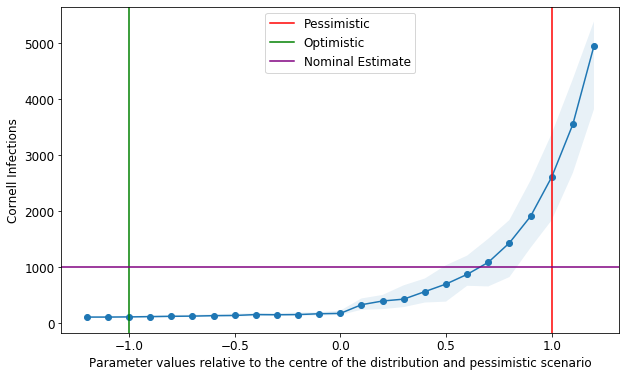

In [156]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'res_cornell_inf_50', marker='o', data=pess_sens_data, label='_nolegend_')
plt.fill_between(x='mult', y1='res_cornell_inf_10', y2='res_cornell_inf_90', alpha=0.1, data=pess_sens_data)

# plt.title('Cornell Infections')
plt.ylabel('Cornell Infections')
plt.xlabel('Parameter values relative to the centre of the distribution and pessimistic scenario')

plt.axvline(1, label='Pessimistic', color='red')
plt.axvline(-1, label='Optimistic', color='green')

plt.axhline(get_stats(nom_res_inf_matrix)[0][1], label='Nominal Estimate', color='purple')

plt.legend()
plt.show()

# Virtual - Residential

### Linear Regression

In [168]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
Y_res_outcomes = np.array(scenario_data[[residential_target]])

virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_cornell_inf_50'
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

X = np.matrix(scenario_data[virtual_columns])

Y_target = Y_res_outcomes - Y_vir_outcomes

reg = LinearRegression().fit(X, Y_target)

print("Intercept: {:.2f}".format(reg.intercept_[0]))
for col, coef in zip(virtual_columns, reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))

Intercept: 17285.34
asymp_prob_mult: -4122.08
inital_prev_mult: 420.77
R0: -2276.72
outside_inf_mult: -93.43
daily_self_report_prob: 1788.45
ct_mult: 444.61
ct_testing_ratio: 180.41
test_sensitivity: -511.41
test_noncompliance: 1734.47
E_time: 194.22
ID_time: -589.80
Sy_time: -5.76
virtual_noncompliance: -2774.91
intermittent_non-compliance: -1654.84
virtual_r0_mult: -6225.34
virtual_pop_size: -1513.95


In [169]:
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
Y_res_outcomes = np.array(scenario_data[[residential_target]])

virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_cornell_inf_50'
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

X = scenario_data[virtual_columns]

Y_target = Y_res_outcomes - Y_vir_outcomes

X = sm.add_constant(X)
model = sm.OLS(Y_target,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     42.54
Date:                Sat, 24 Apr 2021   Prob (F-statistic):           6.09e-53
Time:                        00:41:28   Log-Likelihood:                -1718.5
No. Observations:                 200   AIC:                             3471.
Df Residuals:                     183   BIC:                             3527.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1.729e+04   2460.769      7.024      0.000    1.24e+04    2.21e+04
asymp_prob_mult             -4122.0772    361.994    -11.387      0.000   -4836.296   -3407.858
inital_prev_mult              420.7727    361.868      1.163      0.246    -293.197    1134.742
R0                          -2276.7187    120.322    -18.922      0.000   -2514.115   -2039.322
outside_inf_mult              -93.4250    354.677     -0.263      0.793    -793.207     606.357
daily_self_report_prob       1788.4518   1221.172      1.465      0.145    -620.936    4197.840
ct_mult                       444.6141    369.384      1.204      0.230    -284.184    1173.412
ct_testing_ratio              180.4051    359.169      0.502      0.616    -528.239     889.049
test_sensitivity             -511.4082    878.268     -0.582      0.561   -2244.242    1221.426
test_noncompliance           1734.4675   3507.732      0.494      0.622   -5186.330    8655.265
E_time                        194.2156    175.202      1.109      0.269    -151.460     539.891
ID_time                      -589.8021    173.052     -3.408      0.001    -931.235    -248.369
Sy_time                        -5.7650    174.184     -0.033      0.974    -349.431     337.901
virtual_noncompliance       -2774.9114    695.872     -3.988      0.000   -4147.874   -1401.948
intermittent_non-compliance -1654.8418    698.749     -2.368      0.019   -3033.482    -276.202
virtual_r0_mult             -6225.3427    645.328     -9.647      0.000   -7498.583   -4952.102
virtual_pop_size            -1513.9535    344.713     -4.392      0.000   -2194.076    -833.831
==============================================================================
Omnibus:                        6.125   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.116
Skew:                           0.428   Prob(JB):                       0.0470
Kurtosis:                       2.999   Cond. No.                         480.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
lr_results = {'Intercept': 17285.34,
'asymp_prob_mult': -4122.08,
'inital_prev_mult': 420.77,
'R0': -2276.72,
'outside_inf_mult': -93.43,
'daily_self_report_prob': 1788.45,
'ct_mult': 444.61,
'ct_testing_ratio': 180.41,
'test_sensitivity': -511.41,
'test_noncompliance': 1734.47,
'E_time': 194.22,
'ID_time': -589.80,
'Sy_time': -5.76,
'virtual_noncompliance': -2774.91,
'intermittent_non-compliance': -1654.84,
'virtual_r0_mult': -6225.34,
'virtual_pop_size': -1513.95}

### Calculating Pessimistic Scenario (v2: res - vir)

In [171]:
range_dict = dict()

for param in uncertainty_params_list:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in uncertainty_params_list:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in uncertainty_params_list:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 0.7806318681910984,
 'inital_prev_mult': 1.0233766320478968,
 'R0': 1.3616146316401145,
 'outside_inf_mult': 0.9948093287728806,
 'daily_self_report_prob': 0.3677898669266991,
 'ct_mult': 1.5247011060075941,
 'ct_testing_ratio': 1.0100230011354447,
 'test_sensitivity': 0.5954540320286656,
 'test_noncompliance': 0.10096361591815281,
 'E_time': 2.043160961820876,
 'ID_time': 2.868930412511828,
 'Sy_time': 11.998719971475191,
 'virtual_noncompliance': 0.46145872445990127,
 'intermittent_non-compliance': 0.4770155989150001,
 'virtual_r0_mult': 1.1378479457918746,
 'virtual_pop_size': 0.41588979231192}

In [172]:
centre_point = dict()
direction = dict()
for param in uncertainty_params_list:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [173]:
def generate_vir_params_norm(conf_level):
    new_params = dict()
    for param in uncertainty_params_list:
        new_params[param] = centre_point[param] + norm.ppf(conf_level) * direction[param]
    return new_params

def generate_vir_params_scalar(mult):
    new_params = dict()
    for param in uncertainty_params_list:
        new_params[param] = centre_point[param] + mult * direction[param] * norm.ppf(0.975)
    return new_params

def transform_vir_param_dict_point(param_dict):
    new_point = list()
    for param in uncertainty_params_list:
        new_point.append(param_dict[param])
    return new_point

# pess_scenario, transform_res_param_dict_point(generate_res_params(0.975))

In [164]:
def run_both_simulations(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), (vir_params_list, vir_interaction_matrix, vir_group_names) = adjust_params(uncertainty_point)

    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
        
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

    # Running virtual sims
    print('Virtual Sim', point_id)
    virtual_tests_per_day, virtual_inf_matrix, virtual_hosp_matrix = evaluate_testing_policy(vir_params_list, vir_interaction_matrix, vir_group_names, virtual_test_policy, 112, 50)
    
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix], file)
    file.close()
    return

In [166]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_both_simulations, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [167]:
processes = []

mult_levels = np.linspace(-1.2, 1.2, 25)

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    p = run_new_process(new_point, 'apr_22_pess_scenarios/res-vir_pess_sensitivity_'+str(mult)+'.dill', mult)
    processes.append(p)

print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim -0.8999999999999999


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim -1.2
Res Sim -0.8


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim -1.0999999999999999


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim -1.0


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim -0.7


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim -0.5
Res Sim -0.4
Res Sim -0.6
Res Sim -0.20000000000000007
Res Sim -0.10000000000000009
Res Sim -0.30000000000000004
Res Sim 0.09999999999999987
Res Sim 0.2999999999999998
Res Sim 0.19999999999999996
Res Sim 0.0
Res Sim 0.3999999999999999
Res Sim 0.5999999999999999
Res Sim 0.5
launched 25 processes
Res Sim 0.7
Res Sim 0.7999999999999998
Res Sim 0.8999999999999997
Res Sim 1.0999999999999999
Res Sim 1.2
Res Sim 0.9999999999999998
Virtual Sim 0.9999999999999998
Virtual Sim 0.3999999999999999
Virtual Sim 0.09999999999999987
Virtual Sim 0.2999999999999998
Virtual Sim 1.0999999999999999
Virtual Sim 1.2
Virtual Sim 0.8999999999999997
Virtual Sim 0.19999999999999996
Virtual Sim 0.7999999999999998
Virtual Sim -0.4
Virtual Sim 0.5999999999999999
Virtual Sim 0.5
Virtual Sim -0.8
Virtual Sim -0.20000000000000007
Virtual Sim -0.30000000000000004
Virtual Sim 0.0
Virtual Sim -0.10000000000000009
Virtual Sim 0.7
Virtual Sim -1.0
Virtual Sim -0.7
Virtual Sim -0.8999999999999999
Virtual Sim -1.

### Loading Results

In [174]:
res_vir_pess = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for mult in mult_levels:
    file = open('apr_22_pess_scenarios/res-vir_pess_sensitivity_'+str(mult)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    res_vir_pess = res_vir_pess.append(new_row, ignore_index=True)

In [175]:
res_vir_pess

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90,vir_cornell_inf_10,vir_cornell_inf_50,vir_cornell_inf_90,vir_ithaca_inf_10,vir_ithaca_inf_50,vir_ithaca_inf_90
0,-1.2,2001.8,2655.0,3380.7,485.4,574.0,667.4,7549.3,7719.0,7847.2,3649.0,3878.0,4099.0
1,-1.1,1488.1,2088.0,2608.4,413.7,505.0,585.4,7209.0,7413.0,7504.0,3200.5,3320.0,3500.7
2,-1.0,1191.0,1697.5,2207.6,362.0,417.0,499.0,6945.9,7134.0,7312.0,2719.0,2959.5,3125.1
3,-0.9,946.5,1361.0,2040.9,337.7,386.0,455.1,6583.4,6734.5,6914.3,2383.4,2517.0,2691.2
4,-0.8,706.5,1140.5,1560.2,300.3,327.0,390.3,6029.0,6296.5,6564.9,1982.1,2176.5,2335.4
5,-0.7,505.8,879.0,1166.1,260.0,292.0,337.9,5445.7,5714.5,5975.0,1612.8,1756.5,1934.0
6,-0.6,550.7,769.5,998.7,250.4,289.0,334.8,4575.9,5048.5,5500.8,1257.4,1427.0,1593.8
7,-0.5,377.8,595.5,923.4,225.0,259.5,307.1,3626.6,4232.0,4803.6,960.0,1144.0,1347.5
8,-0.4,427.7,562.0,780.8,219.7,247.5,280.7,2395.1,3524.0,4013.9,645.7,882.5,1055.1
9,-0.3,304.8,462.5,607.4,205.8,235.0,263.1,1991.2,2652.5,3233.3,506.7,678.5,806.1


In [176]:
# res_vir_pess['res-vir_cornell_inf_50'] = res_vir_pess['res_cornell_inf_50'] - res_vir_pess['vir_cornell_inf_50']
# res_vir_pess['res-vir_cornell_inf_10'] = res_vir_pess['res_cornell_inf_10'] - res_vir_pess['vir_cornell_inf_10']
# res_vir_pess['res-vir_cornell_inf_90'] = res_vir_pess['res_cornell_inf_90'] - res_vir_pess['vir_cornell_inf_90']

res_vir_pess['vir-res_cornell_inf_50'] = res_vir_pess['vir_cornell_inf_50'] - res_vir_pess['res_cornell_inf_50']
res_vir_pess['vir-res_cornell_inf_10'] = res_vir_pess['vir_cornell_inf_10'] - res_vir_pess['res_cornell_inf_10']
res_vir_pess['vir-res_cornell_inf_90'] = res_vir_pess['vir_cornell_inf_90'] - res_vir_pess['res_cornell_inf_90']

### Estimating Nominal Res - Virtual

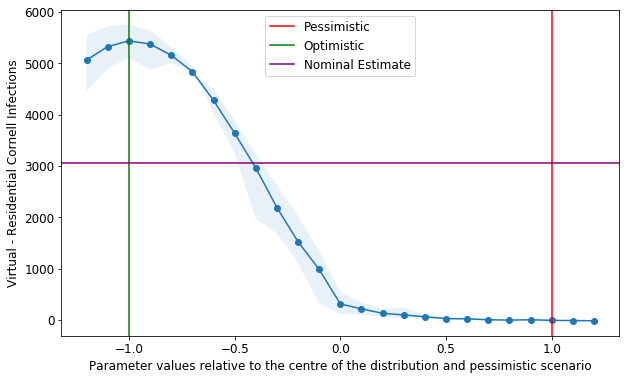

In [177]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'vir-res_cornell_inf_50', marker='o', data=res_vir_pess, label='_nolegend_')
plt.fill_between(x='mult', y1='vir-res_cornell_inf_10', y2='vir-res_cornell_inf_90', alpha=0.1, data=res_vir_pess)

# plt.title('Cornell Infections')
plt.ylabel('Virtual - Residential Cornell Infections')
plt.xlabel('Parameter values relative to the centre of the distribution and pessimistic scenario')

plt.axvline(1, label='Pessimistic', color='red')
plt.axvline(-1, label='Optimistic', color='green')

plt.axhline(get_stats(nom_vir_inf_matrix)[0][1] - get_stats(nom_res_inf_matrix)[0][1], label='Nominal Estimate', color='purple')

plt.legend()
plt.show()

# Sampling from prior

### Constructing sampling distribution

In [73]:
param_uncertainty
uncertainty_params_list

mu = list()
var = list()

for param in uncertainty_params_list:
    mu.append(np.mean(param_uncertainty[param]))
    sd = (param_uncertainty[param][1] - np.mean(param_uncertainty[param])) / norm.ppf(0.975)
    var.append(sd**2)

In [78]:
np.random.multivariate_normal(np.array(mu), np.diag(var))

array([ 1.21053187,  0.54154963,  1.86451836,  1.15477335,  0.45277975,
        1.23557287,  1.03106424,  0.28211095,  0.0892226 ,  2.412692  ,
        2.87059338, 12.03590384,  0.49848994,  0.39265187,  1.10859879,
        0.53012966])

In [79]:
def run_simulation(uncertainty_point, filename, point_id=None):
    # get params
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(uncertainty_point)

    # run simulations
    # Residential Simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    virtual_test_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]
    
#     print(res_params_list[0]['severity_prevalence'])
#     for params in res_params_list:
#         if params['test_protocol_QFNR'] < 0 or params['test_protocol_QFNR'] > 1:
#             print(params['test_protocol_QFNR'])
#     for params in virtual_params_list:
#         if params['test_protocol_QFNR'] < 0 or params['test_protocol_QFNR'] > 1:
#             print(params['test_protocol_QFNR'])
    
    # Running res sims
    print('Res Sim', point_id)
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)
    
    # Running virtual sims
    print('Virtual Sim', point_id)
    virtual_tests_per_day, virtual_inf_matrix, virtual_hosp_matrix = evaluate_testing_policy(virtual_params_list, virtual_interaction_matrix, virtual_group_names, virtual_test_policy, 112, 50)
    
    # save output
    file = open(filename, mode='wb')
    dill.dump([uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix], file)
    file.close()    
    return

In [80]:
# Parallelization code
def run_new_process(uncertainty_point, filename, point_id):
    p = Process(target = run_simulation, args = (uncertainty_point, filename, point_id))
    p.start()
    return p

In [82]:
np.random.seed(12345)
processes = []

for i in range(200):
    # sample from prior
    point = np.random.multivariate_normal(np.array(mu), np.diag(var))
    # run simulations
    p = run_new_process(point, 'apr_23_scenarios/prior_'+str(i)+'.dill', i)
    processes.append(p)

print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 2


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 1
Res Sim 4


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 0
Res Sim 5


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 6


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 7


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 8


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 9


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 3
Res Sim 10


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 11
Res Sim 12


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 13


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 14


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 15


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 17


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 16


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 19


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 18


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 21
Res Sim 20


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 24


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 23
Res Sim 22


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 26
Res Sim 27
Res Sim 25
Res Sim 28


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 29


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 31


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 30
Res Sim 32


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 33


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Res Sim 35


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 36


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 39


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 41


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 34
Res Sim 37
Res Sim 40


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 38


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 42


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 46


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 43
Res Sim 45


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 44
Res Sim 48


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 49


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 47


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 50


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 51


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 52


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 53
Res Sim 54


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 55


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 56


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 57


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 58


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 60
Res Sim 59


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 61
Res Sim 62


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 64
Res Sim 63


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 65


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 66


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 69


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 68
Res Sim 67


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 70


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 72
Res Sim 71
Res Sim 74


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 76


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 75


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 73


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 77


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 78


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 80


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 82
Res Sim 83


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 79


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 81


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 84


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 85


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 86


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 90


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 88
Res Sim 87
Res Sim 93


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 95
Res Sim 91


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 96


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 94


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 92
Res Sim 89


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 97
Res Sim 98
Res Sim 99


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 101
Res Sim 104
Res Sim 102
Res Sim 100


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 105
Res Sim 103
Res Sim 108
Res Sim 107


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 106


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 110
Res Sim 111


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 109


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 113
Res Sim 112


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 115


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 114


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 116


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 117


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 119
Res Sim 120
Res Sim 118


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 122


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 121


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 124
Res Sim 123


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 125


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 129
Res Sim 130
Res Sim 126


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 128


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 131
Res Sim 127


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 132


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 133


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 134
Res Sim 136


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 135
Res Sim 137


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 139


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

Res Sim 138


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 141
Res Sim 140


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 142
Res Sim 144


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 143


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 147


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 145
Res Sim 148


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 149
Res Sim 146


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 150


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

Res Sim 151


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 152
Res Sim 153
Res Sim 154


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 155


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 160


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 156
Res Sim 157


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 159
Res Sim 158


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 162


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 161


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 163


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 165


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 164


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 166
Res Sim 168
Res Sim 167


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 169


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

Res Sim 172
Res Sim 173


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 170
Res Sim 171


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

Res Sim 176


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

Res Sim 174
Res Sim 175


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 177
Res Sim 178


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 180


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 179


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 182


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Res Sim 181
Res Sim 184


/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Res Sim 183
launched 200 processes
Res Sim 186
Res Sim 185
Res Sim 187
Res Sim 190
Res Sim 189
Res Sim 191
Res Sim 188
Res Sim 193
Res Sim 192
Res Sim 194
Res Sim 195
Res Sim 196
Res Sim 198
Res Sim 199
Res Sim 197
Virtual Sim 197
Virtual Sim 199
Virtual Sim 198
Virtual Sim 195
Virtual Sim 196
Virtual Sim 194
Virtual Sim 193
Virtual Sim 192
Virtual Sim 191
Virtual Sim 189
Virtual Sim 188
Virtual Sim 190
Virtual Sim 187
Virtual Sim 186
Virtual Sim 185
Virtual Sim 183
Virtual Sim 184
Virtual Sim 182
Virtual Sim 181
Virtual Sim 180
Virtual Sim 179
Virtual Sim 178
Virtual Sim 176
Virtual Sim 177
Virtual Sim 174
Virtual Sim 175
Virtual Sim 171
Virtual Sim 173
Virtual Sim 172
Virtual Sim 169
Virtual Sim 170
Virtual Sim 168
Virtual Sim 167
Virtual Sim 166
Virtual Sim 164
Virtual Sim 165
Virtual Sim 163
Virtual Sim 161
Virtual Sim 157
Virtual Sim 162
Virtual Sim 160
Virtual Sim 159
Virtual Sim 158
Virtual Sim 156
Virtual Sim 155
Virtual Sim 154
Virtual Sim 153
Virtual Sim 152
Virtual Sim 150
V

### Loading Sim Results

In [12]:
prior_data = pd.DataFrame(columns=uncertainty_params_list+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for i in range(200):
    file = open('apr_23_scenarios/prior_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    for index, col_name in enumerate(uncertainty_params_list):
        new_row[col_name] = uncertainty_point[index]

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    prior_data = prior_data.append(new_row, ignore_index=True)

### Distribution of the medians

In [28]:
# neg_entries = 0
# for entry in np.array(prior_data['vir_cornell_inf_50']) - np.array(prior_data['res_cornell_inf_50']):
#     if entry < 0:
#         neg_entries += 1
#         print(entry)
        
# neg_entries

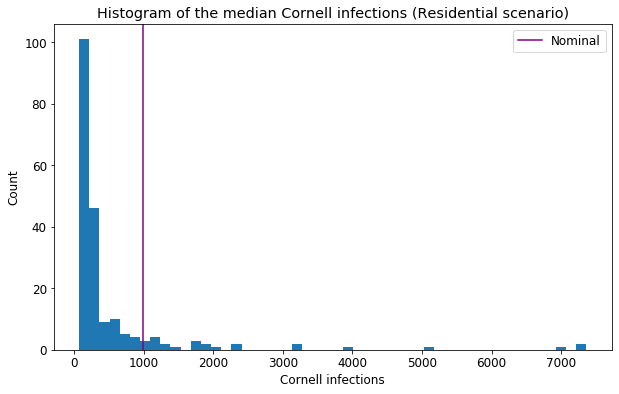

In [157]:
plt.figure(figsize=(10,6))
plt.hist(prior_data['res_cornell_inf_50'], bins=50)
plt.axvline(get_stats(nom_inf_matrix)[0][1], color='purple', label='Nominal')

plt.title('Histogram of the median Cornell infections (Residential scenario)')
plt.xlabel('Cornell infections')
plt.ylabel('Count')
plt.legend()
plt.show()

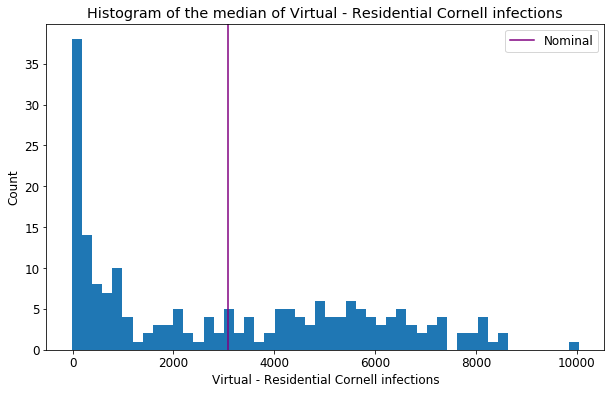

In [20]:
plt.figure(figsize=(10,6))
plt.hist(np.array(prior_data['vir_cornell_inf_50']) - np.array(prior_data['res_cornell_inf_50']), bins=50)
plt.axvline(get_stats(nom_vir_inf_matrix)[0][1] - get_stats(nom_res_inf_matrix)[0][1], color='purple', label='Nominal')

plt.title('Histogram of the median of Virtual - Residential Cornell infections')
plt.xlabel('Virtual - Residential Cornell infections')
plt.ylabel('Count')
plt.legend()
plt.show()

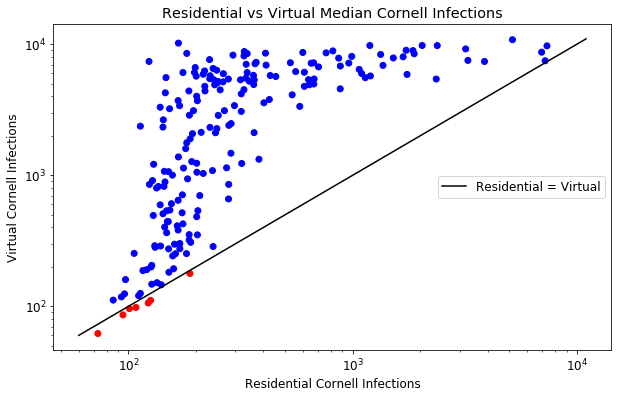

In [38]:
plt.figure(figsize=(10,6))
colors = list()
for res_inf, vir_inf in zip(list(prior_data['res_cornell_inf_50']), list(prior_data['vir_cornell_inf_50'])):
    if res_inf > vir_inf:
        colors.append('red')
    elif res_inf < vir_inf:
        colors.append('blue')
    else:
        colors.append('black')

plt.scatter(x='res_cornell_inf_50', y='vir_cornell_inf_50', data=prior_data, c=colors, label=None)
plt.plot(range(60,11000), range(60,11000), color='black', label='Residential = Virtual')
plt.title('Residential vs Virtual Median Cornell Infections')
plt.xlabel('Residential Cornell Infections')
plt.ylabel('Virtual Cornell Infections')
plt.legend(loc='right')
plt.yscale('log')
plt.xscale('log')
plt.show()

### Distribution of all sims

In [115]:
np.array(res_inf_matrix)[:,:-1].sum(axis=1), np.array()
# np.sum(res_inf_matrix, axis=1)

array([117, 143, 145, 144, 159, 170, 166, 143, 124, 125, 146, 126, 141,
       130, 124, 123, 123, 169, 139, 158, 177, 138, 118, 142, 166, 151,
       170, 135, 118, 159, 158, 148, 155, 124, 140, 171, 162, 162, 180,
       163, 126, 157, 117, 151, 146, 145, 197, 138, 168, 162])

In [116]:
res_cornell_inf = list()
vir_cornell_inf = list()

for i in range(200):
    file = open('apr_23_scenarios/prior_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()
    
    res_cornell_inf.append(np.array(res_inf_matrix)[:,:-1].sum(axis=1))
    vir_cornell_inf.append(np.array(virtual_inf_matrix)[:,:-1].sum(axis=1))

res_cornell_inf = np.concatenate(res_cornell_inf)
vir_cornell_inf = np.concatenate(vir_cornell_inf)

In [135]:
# res_vir_df = pd.DataFrame({'inf': np.concatenate([res_cornell_inf, vir_cornell_inf]), 'color': ['Residential']*len(res_cornell_inf) + ['Virtual']*len(vir_cornell_inf)})
np.array([res_cornell_inf, vir_cornell_inf]).T

array([[ 196., 2660.],
       [ 198., 4739.],
       [ 151., 4101.],
       ...,
       [ 138., 1026.],
       [ 168.,  708.],
       [ 162.,  734.]])

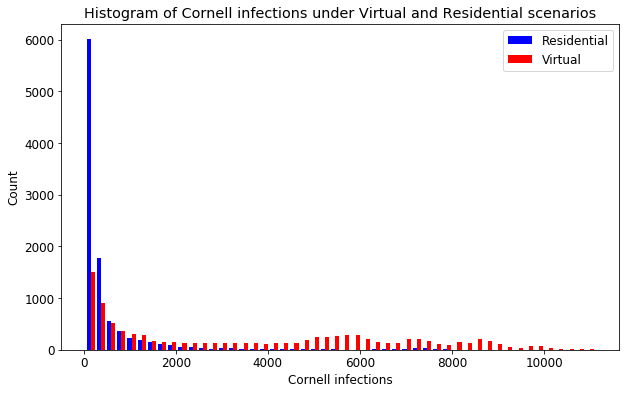

In [138]:
plt.figure(figsize=(10,6))
plt.hist(np.array([res_cornell_inf, vir_cornell_inf]).T, bins=50, color=['blue', 'red'], label=['Residential', 'Virtual'])
# plt.axvline(get_stats(nom_vir_inf_matrix)[0][1] - get_stats(nom_res_inf_matrix)[0][1], color='purple', label='Nominal')

plt.title('Histogram of Cornell infections under Virtual and Residential scenarios')
plt.xlabel('Cornell infections')
plt.ylabel('Count')
plt.legend()
plt.show()

# Old Code

In [22]:
# conf_levels = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]
# conf_data = pd.DataFrame(columns=['conf_level']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

mult_levels = np.linspace(-1.2, 1.2, 25)
mult_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    print(mult)
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(new_point)
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
    mult_data = mult_data.append(new_row, ignore_index=True)

-1.2


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


-1.0999999999999999
-1.0
-0.8999999999999999
-0.8
-0.7
-0.6
-0.5
-0.4
-0.30000000000000004
-0.20000000000000007
-0.10000000000000009
0.0
0.09999999999999987
0.19999999999999996
0.2999999999999998
0.3999999999999999
0.5
0.5999999999999999
0.7
0.7999999999999998
0.8999999999999997
0.9999999999999998
1.0999999999999999
1.2


In [23]:
mult_data

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90
0,-1.2,85.0,95.0,108.1,116.0,127.5,145.0
1,-1.1,86.8,98.0,112.0,121.0,132.0,142.8
2,-1.0,90.0,102.5,119.1,132.9,139.5,154.4
3,-0.9,98.0,107.5,123.0,126.0,145.5,155.2
4,-0.8,93.8,111.5,132.2,132.9,142.0,163.0
5,-0.7,101.0,115.5,141.1,134.9,148.5,164.2
6,-0.6,110.4,129.0,152.1,144.9,159.0,172.2
7,-0.5,113.9,130.5,147.2,145.2,164.0,178.3
8,-0.4,122.0,146.5,169.0,150.8,168.5,184.3
9,-0.3,127.0,159.5,187.0,154.8,176.5,193.3


In [25]:
# Nominal Scenario
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


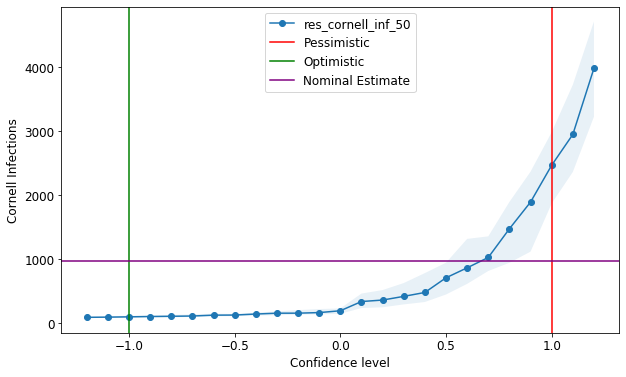

In [29]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'res_cornell_inf_50', marker='o', data=mult_data)
plt.fill_between(x='mult', y1='res_cornell_inf_10', y2='res_cornell_inf_90', alpha=0.1, data=mult_data)

# plt.title('Cornell Infections')
plt.ylabel('Cornell Infections')
plt.xlabel('Confidence level')

plt.axvline(1, label='Pessimistic', color='red')
plt.axvline(-1, label='Optimistic', color='green')

plt.axhline(get_stats(nom_inf_matrix)[0][1], label='Nominal Estimate', color='purple')

plt.legend()
plt.show()

# Proposal 1
# x-axis: Mass in hyper-ellipsoid, y: performance of worst configuration in the hyper ellipsoid (according to linear model), centre: 0

# Describe graph as 0 - 1 being ellipsoid, 0.5 is centre. Beyond 0, 1 is beyond ellipsoid
# Linear transformation of x-axis: (z-score). 0 is centre, -1 is 1 sd optimistic, +1 is 1 sd pessimistic

# (-1) to 1 where -1 is optimistic, +1 is pessimistic

# Proposal 2
# hyperplane orthogonal to line, integrate probability density over half-space

# Residential - Virtual

In [30]:
virtual_columns = scenario_data.columns[0:16]
virtual_infs = 'vir_cornell_inf_50'
X_vir = np.matrix(scenario_data[virtual_columns])
Y_vir_outcomes = np.array(scenario_data[[virtual_infs]])

Y_vir_target = Y_res_outcomes - Y_vir_outcomes

vir_reg = LinearRegression().fit(X_vir, Y_vir_target)
print("Intercept: {:.2f}".format(vir_reg.intercept_[0]))
for col, coef in zip(virtual_columns, vir_reg.coef_[0]):
    print("{}: {:.2f}".format(col, coef))


Intercept: 10309.46
asymp_prob_mult: -3676.94
inital_prev_mult: 718.62
R0: -1855.12
outside_inf_mult: -46.64
daily_self_report_prob: 1292.63
ct_mult: 1018.80
ct_testing_ratio: 391.35
test_sensitivity: 1331.83
test_noncompliance: 111.85
E_time: 226.41
ID_time: -156.81
Sy_time: -31.22
virtual_noncompliance: -3053.47
intermittent_non-compliance: -316.40
virtual_r0_mult: -4391.05
virtual_pop_size: 5.12


In [ ]:
virtual_lr_results = {'Intercept': -110.67,
'asymp_prob_mult': 164.51,
'inital_prev_mult': 42.82,
'R0': 107.74,
'outside_inf_mult': 138.03,
'daily_self_report_prob': -165.30,
'ct_mult': -160.51,
'ct_testing_ratio': -83.95,
'test_sensitivity': -255.78,
'test_noncompliance': 303.68,
'E_time': 6.59,
'ID_time': -8.20,
'Sy_time': 22.56}

In [ ]:
param_uncertainty


mu = list()
var = list()

In [41]:
pess_scenario_point = list()
for param in res_params:
    pess_scenario_point.append(pess_scenario[param])
for _ in range(4):
    pess_scenario_point.append(0)
(res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(pess_scenario_point)
res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 50)

/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/aaj54/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


In [42]:
get_stats(res_inf_matrix)

(array([1453.5, 1893.5, 2479.1]), array([511.8, 568. , 649. ]))

In [43]:
nom_params_list, nom_interaction_matrix, nom_group_names = get_nominal_params()
nom_tests_per_day, nom_inf_matrix, nom_hosp_matrix = evaluate_testing_policy(nom_params_list, nom_interaction_matrix, nom_group_names, res_test_policy, 112, 50)

In [44]:
get_stats(nom_inf_matrix)

(array([ 616.1,  974.5, 1304. ]), array([261.9, 298. , 346.5]))

In [ ]:
alpha_ellipsoid = 0.95
def get_alpha_coords(alpha):
    for param in param_uncertainty.keys():
        LB = param_uncertainty[param][0]
        UB = param_uncertainty[param][1]
        new_value = LB + (UB-LB) * (norm.ppf(1+alpha/2) / norm.ppf(1+alpha_ellipsoid/2))
        